In [1]:
!pip install torchdiffeq

In [2]:
import torch
print(torch.cuda.is_available())   # True여야 GPU 사용 가능
print(torch.cuda.device_count())   # GPU 개수
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
NVIDIA A100-SXM4-40GB


In [3]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)                  # Python random 고정
    np.random.seed(seed)               # Numpy random 고정
    torch.manual_seed(seed)            # PyTorch CPU 고정
    torch.cuda.manual_seed(seed)       # PyTorch GPU 단일 고정

    # 연산 재현성 보장 (속도는 약간 손해봄)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((128 , 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,)),  # [-1,1] 범위
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [-1,1] 범위
    #transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset = Subset(train_dataset, range(50000))
train_loader = DataLoader(subset, batch_size=64, shuffle=True)

val_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_subset = Subset(val_dataset, range(5000))
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

dim = 128

# --------------------------------------
# 2. 벡터장 모델
# --------------------------------------
# CNN 기반 Vector Field
class ConvVectorField(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        act = nn.SiLU

        # 128x128
        self.enc1 = nn.Sequential(
            nn.Conv2d(3+1, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            act(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            act(),
        )
        self.down1 = nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=2, padding=1)   # 128->64

        # 64x64
        self.enc2 = nn.Sequential(
            nn.GroupNorm(16, hidden_dim*2),
            act(),
            nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1),
            nn.GroupNorm(16, hidden_dim*2),
            act(),
        )
        self.down2 = nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, stride=2, padding=1) # 64->32

        # 32x32
        self.enc3 = nn.Sequential(
            nn.GroupNorm(32, hidden_dim*4),
            act(),
            nn.Conv2d(hidden_dim*4, hidden_dim*4, 3, padding=1),
            nn.GroupNorm(32, hidden_dim*4),
            act(),
        )
        self.down3 = nn.Conv2d(hidden_dim*4, hidden_dim*8, 3, stride=2, padding=1) # 32->16

        # 16x16
        self.enc4 = nn.Sequential(
            nn.GroupNorm(32, hidden_dim*8),
            act(),
            nn.Conv2d(hidden_dim*8, hidden_dim*8, 3, padding=1),
            nn.GroupNorm(32, hidden_dim*8),
            act(),
        )
        self.down4 = nn.Conv2d(hidden_dim*8, hidden_dim*16, 3, stride=2, padding=1) # 16->8

        # 8x8 bottleneck
        self.bottleneck = nn.Sequential(
            nn.GroupNorm(32, hidden_dim*16),
            act(),
            nn.Conv2d(hidden_dim*16, hidden_dim*16, 3, padding=1),
            nn.GroupNorm(32, hidden_dim*16),
            act(),
        )

        # Up: 8->16
        self.up1 = nn.ConvTranspose2d(hidden_dim*16, hidden_dim*8, 4, stride=2, padding=1)
        self.dec1 = nn.Sequential(
            nn.GroupNorm(32, hidden_dim*8 + hidden_dim*8),   # concat(enc4)
            act(),
            nn.Conv2d(hidden_dim*8 + hidden_dim*8, hidden_dim*8, 3, padding=1),
            nn.GroupNorm(32, hidden_dim*8),
            act(),
        )

        # Up: 16->32
        self.up2 = nn.ConvTranspose2d(hidden_dim*8, hidden_dim*4, 4, stride=2, padding=1)
        self.dec2 = nn.Sequential(
            nn.GroupNorm(32, hidden_dim*4 + hidden_dim*4),   # concat(enc3)
            act(),
            nn.Conv2d(hidden_dim*4 + hidden_dim*4, hidden_dim*4, 3, padding=1),
            nn.GroupNorm(32, hidden_dim*4),
            act(),
        )

        # Up: 32->64
        self.up3 = nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, stride=2, padding=1)
        self.dec3 = nn.Sequential(
            nn.GroupNorm(16, hidden_dim*2 + hidden_dim*2),   # concat(enc2)
            act(),
            nn.Conv2d(hidden_dim*2 + hidden_dim*2, hidden_dim*2, 3, padding=1),
            nn.GroupNorm(16, hidden_dim*2),
            act(),
        )

        # Up: 64->128
        self.up4 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=2, padding=1)
        self.dec4 = nn.Sequential(
            nn.GroupNorm(8, hidden_dim + hidden_dim),        # concat(enc1)
            act(),
            nn.Conv2d(hidden_dim + hidden_dim, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            act(),
        )

        self.conv_out = nn.Conv2d(hidden_dim, 3, 3, padding=1)

    def forward(self, x, t):
        # x: (B,3,128,128), t: (B,1,128,128)
        xt = torch.cat([x, t], dim=1)   # (B,4,128,128)

        e1 = self.enc1(xt)              # 128,h
        h  = self.down1(e1)             # 64,2h
        e2 = self.enc2(h)               # 64,2h
        h  = self.down2(e2)             # 32,4h
        e3 = self.enc3(h)               # 32,4h
        h  = self.down3(e3)             # 16,8h
        e4 = self.enc4(h)               # 16,8h
        h  = self.down4(e4)             # 8,16h

        h = self.bottleneck(h)          # 8,16h

        h = self.up1(h)                 # 16,8h
        h = torch.cat([h, e4], dim=1)   # 16,16h
        h = self.dec1(h)                # 16,8h

        h = self.up2(h)                 # 32,4h
        h = torch.cat([h, e3], dim=1)   # 32,8h
        h = self.dec2(h)                # 32,4h

        h = self.up3(h)                 # 64,2h
        h = torch.cat([h, e2], dim=1)   # 64,4h
        h = self.dec3(h)                # 64,2h

        h = self.up4(h)                 # 128,h
        h = torch.cat([h, e1], dim=1)   # 128,2h
        h = self.dec4(h)                # 128,h

        out = self.conv_out(h)          # (B,3,128,128)
        return out


# --------------------------------------
# 3. Flow Matching Loss

# 양방향 학습
# --------------------------------------
def divergence_field(u):
    """
    u: (B, C=3, H, W) velocity field
    """
    # 채널별로 하나씩 꺼내서 gradient 계산
    u_x = u[:, 0]  # (B,H,W)
    u_y = u[:, 1]  # (B,H,W)

    dudx = torch.gradient(u_x, dim=1)[0]  # ∂u_x/∂x  (height 방향)
    dudy = torch.gradient(u_y, dim=2)[0]  # ∂u_y/∂y  (width 방향)

    div = dudx + dudy
    return div


def flow_matching_loss(model, x0, x1, t, lambda_div=0.01):
    # t scalar
    t_scalar = t[:, :1, :1, :1]

    # Forward (x0 -> x1)
    xt_fwd = (1 - t) * x0 + t * x1
    ut_target_fwd = x1 - x0
    input_t_fwd = t_scalar.expand(-1, 1, x1.shape[2], x1.shape[3])
    ut_pred_fwd = model(xt_fwd, input_t_fwd)

    # Forward loss
    w = (t_scalar * (1 - t_scalar) + 1e-3)
    loss_fwd = (w * (ut_pred_fwd - ut_target_fwd).pow(2)).mean()

    # Divergence-free loss
    div = divergence_field(ut_pred_fwd)   # (B,H,W)
    loss_div = (div.pow(2)).mean()

    return loss_fwd + lambda_div * loss_div
# --------------------------------------
# 4. 학습 루프
# --------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvVectorField(dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

visualize = 'False'
epochs = 300
losses = []
val_losses = []
accumulation_steps = 8

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        x1 = images.to(device)                    # target = CIFAR image
        x0 = torch.randn_like(x1).to(device)      # source = Gaussian
        t_scalar = Beta(0.5, 0.5).sample((x1.size(0), 1, 1, 1)).to(device)
        t = t_scalar.expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])

        loss = flow_matching_loss(model, x0, x1, t)

        loss = loss / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            x1 = images.to(device)
            x0 = torch.randn_like(x1).to(device)
            t_scalar = Beta(0.5, 0.5).sample((x1.size(0), 1, 1, 1)).to(device)
            t = t_scalar.expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])
            val_loss = flow_matching_loss(model, x0, x1, t)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # ---- Visualization ----
    if visualize == 'True':
        if (epoch+1) % 1 == 0:
            n_show = 3

            # 시각화 전용 난수 생성기
            vis_gen = torch.Generator(device=device).manual_seed(0)

            sample_imgs, _ = next(iter(val_loader))
            x1_vis = sample_imgs[:n_show].to(device)
            x0_vis = torch.randn_like(x1_vis)

            # 고정 t
            t_scalar = torch.full((n_show,1,1,1), 0.7, device=device)
            t_vis = t_scalar.expand_as(x1_vis)

            with torch.no_grad():
                xt  = (1 - t_vis) * x0_vis + t_vis * x1_vis
                ut  = model(xt, t_scalar.expand(-1,1,x1_vis.shape[2],x1_vis.shape[3]))
                xhat = xt + (1 - t_vis) * ut           # 복원

                # 모니터링용 재구성 MSE
                recon_mse = F.mse_loss(xhat, x1_vis).item()

                # 0~1로 스케일
                x0_show   = (x0_vis.clamp(-1,1) + 1)/2
                x1_show   = (x1_vis.clamp(-1,1) + 1)/2
                xhat_show = (xhat.clamp(-1,1) + 1)/2

            fig, axes = plt.subplots(3, n_show, figsize=(n_show*3, 9))
            for i in range(n_show):
                axes[0, i].imshow(x0_show[i].permute(1,2,0).cpu().numpy()); axes[0, i].set_title("x0 (noise)"); axes[0, i].axis("off")
                axes[1, i].imshow(xhat_show[i].permute(1,2,0).cpu().numpy()); axes[1, i].set_title("Recon (x̂)"); axes[1, i].axis("off")
                axes[2, i].imshow(x1_show[i].permute(1,2,0).cpu().numpy()); axes[2, i].set_title("x1 (target)"); axes[2, i].axis("off")

            plt.suptitle(f"Epoch {epoch+1} Samples | recon MSE: {recon_mse:.4f}")
            plt.show()

Epoch 1, Loss: 0.0023
Epoch 2, Loss: 0.0020
Epoch 3, Loss: 0.0021
Epoch 4, Loss: 0.0020
Epoch 5, Loss: 0.0019
Epoch 6, Loss: 0.0014
Epoch 7, Loss: 0.0017
Epoch 8, Loss: 0.0015
Epoch 9, Loss: 0.0013
Epoch 10, Loss: 0.0013
Epoch 11, Loss: 0.0015
Epoch 12, Loss: 0.0015
Epoch 13, Loss: 0.0016
Epoch 14, Loss: 0.0015
Epoch 15, Loss: 0.0013
Epoch 16, Loss: 0.0013
Epoch 17, Loss: 0.0011
Epoch 18, Loss: 0.0015
Epoch 19, Loss: 0.0016
Epoch 20, Loss: 0.0015
Epoch 21, Loss: 0.0017
Epoch 22, Loss: 0.0015
Epoch 23, Loss: 0.0015
Epoch 24, Loss: 0.0017
Epoch 25, Loss: 0.0014
Epoch 26, Loss: 0.0014
Epoch 27, Loss: 0.0013
Epoch 28, Loss: 0.0015


KeyboardInterrupt: 

In [ ]:
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    total_loss = 0
    count = 0
    for images, _ in test_loader:
        x1 = images.to(device)
        x0 = torch.randn_like(x1).to(device)
        t_scalar = Beta(0.5, 0.5).sample((x1.size(0), 1, 1, 1)).to(device)
        t = t_scalar.expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])

        loss = flow_matching_loss(model, x0, x1, t)
        total_loss += loss.item() * len(x1)
        count += len(x1)
    print("Test Loss:", total_loss / count)

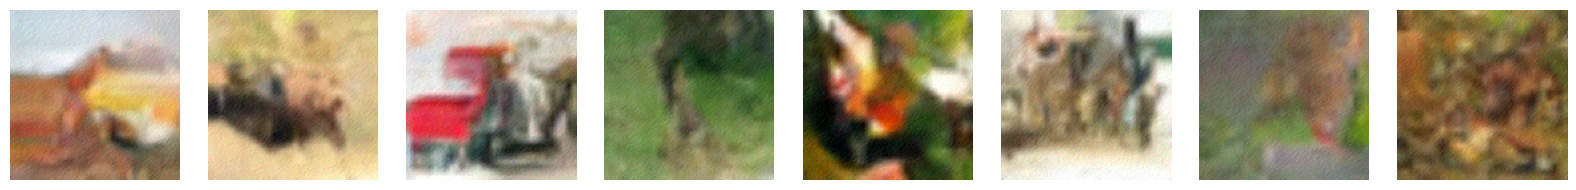

In [5]:
from torchdiffeq import odeint

def sample_images(model, n_samples=8, steps=40, H=128, W=128, device="cuda"):
    model.eval()
    with torch.no_grad():
        # 초기 노이즈
        x0 = torch.randn(n_samples, 3, H, W, device=device)

        # ODE 함수 정의
        def ode_func(t, x_flat):
            x = x_flat.view(n_samples, 3, H, W)
            t_img = t.reshape(1,1,1,1).to(device).expand(n_samples, 1, H, W)
            dx = model(x, t_img)   # (B,3,H,W)
            return dx.view(-1)

        # t=ε부터 시작 (0 근처는 학습이 약해서 불안정)
        eps = 1e-3
        ts = torch.linspace(eps, 1.0, steps, device=device)

        # 적분 (rk4 방식)
        xT = odeint(ode_func, x0.view(-1), ts, method="rk4")[-1]
        xT = xT.view(n_samples, 3, H, W).clamp_(-1, 1)
        return xT.cpu()


model.to(device)
samples = sample_images(model, n_samples=8, steps=40, H=128, W=128, device=device)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    img = samples[i].permute(1,2,0).numpy()
    img = (img + 1) / 2.0   # [-1,1] → [0,1]
    ax.imshow(img.clip(0,1))
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Model load**

In [ ]:
ckpt = torch.load("./checkpoints/checkpoint_epoch_100.pth", map_location=device)

model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch = ckpt["epoch"]
print(f"🔄 Resumed from epoch {start_epoch}, last loss = {ckpt['loss']:.4f}")